# Bayesian Linear Regression (Solutions)

**Recitation by Dr. Duygu Ataman**

_03/29/2024, 09:30, 14:00 at Room 150_

_03/29/2024, 10:45, 13:45 Office Hours at Room 524 (For any follow-up questions)_

This notebook aims to revise logistic regression models using PyTorch and pandas libraries in the flower recognition application.

## Multi-class classification with logistic regression

In this exercise, we will implement a logistic regression model on multi-class classification. We will use the [Iris](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset) flower data set which contains different physical properties from three related species of Iris flowers collected by Edgar Anderson. It was first used by British statistician and biologist Ronald Fisher in 1936 for his pioneering study on linear discriminant analysis [1].

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg" width="200"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg" width="200" />
  <img src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Iris_virginica.jpg" width="200" />
</div>

*Images from Wikipedia.*

[1] Fisher, R.A. “The use of multiple measurements in taxonomic problems” Annual Eugenics, 7, Part II, 179-188 (1936).

We can load the data set automatically using the [sklearn](https://scikit-learn.org/stable/) library.

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

iris_data = load_iris()
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['target'] = pd.Series(iris_data.target)

df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We can start by doing some analysis. Please write a short analysis code to count how many samples are there from each class of flower. Plot the count as a bar graph.

N = 150 data points


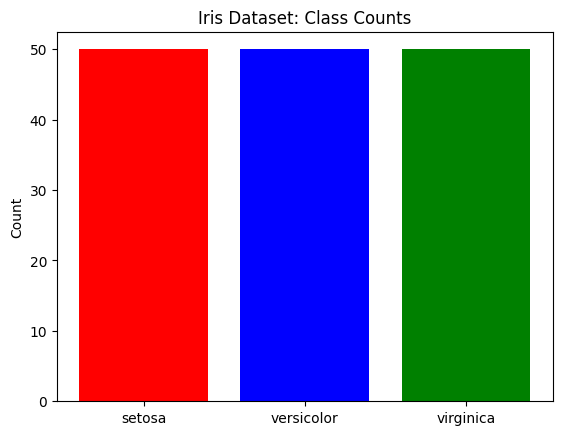

In [ ]:
import matplotlib.pyplot as plt

# Count the number of classes and plot.
N = len(df) # The number of data points.
print('N = {:d} data points'.format(N))

# Give a barplot of each class.
plt.figure()
plt.bar([0,1,2], df['target'].value_counts(ascending = True), color = ['r', 'b', 'g'], tick_label = iris_data.target_names)
plt.ylabel('Count')
plt.title('Iris Dataset: Class Counts');



Next, we will create a training and testing split. Please process the data to convert to tensors and store as training and testing tensors. Make sure the data is numeric and clean. Note that we also need to define the input and output to our classification model.

In [ ]:
import torch

# Write data processing and splitting routine
df = df.dropna()
datatensor = torch.tensor(df.values)

# Randomly select 80% of the examples for training,
# remaining 20% will be for testing
train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
traindata = torch.stack([t for t in train])
testdata = torch.stack([t for t in test])

# We can create separate tensors to input and output to the model
train_features = traindata[:,0:4]
test_features = testdata[:,0:4]
train_target = traindata[:,4].unsqueeze(1)
test_target = testdata[:,4]

# In case of multi-class classification we will reorganize the output to 3 dimensions each representing
# the probability of an individual class
train_mc = torch.zeros(train_target.shape[0], 3)
indices = torch.cat([torch.arange(train_target.shape[0]).unsqueeze(1), train_target], dim=1).int()
train_mc = torch.stack([train_mc[i].index_fill_(dim=0, index=train_target[i].long(), value=1) for i in torch.arange(train_target.shape[0])]).double()
print("New format for the training target data: ", train_mc[0:10,:])


New format for the training target data:  tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=torch.float64)


Let's define again a PyTorch Dataset type class to store and easily iterate over the Iris Data Set.

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class IrisDataset(Dataset):
  def __init__(self, train_in, train_out):
        # Initialize data
        self.n_samples = train_in.shape[0]
        self.x_data = train_in # size [n_samples, n_features]
        self.y_data = train_out # size [n_samples, 1]

  # support indexing such that dataset[i] can be used to get i-th sample
  def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

  # we can call len(dataset) to return the size
  def __len__(self):
      return self.n_samples

Define a logistic regression model and create a training routine to train the model on the training data. Plot the learning curve. Make sure the training is stable and model converges by tuning the hyperparameters, including the batch size and learning rate.

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=True) # a default Linear projection layer with weights A and bias B s.t. y = A*x + b
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        y = self.linear(x)
        z = self.act(y)
        return z

The cross-entropy in training is:  tensor(0.3843, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)


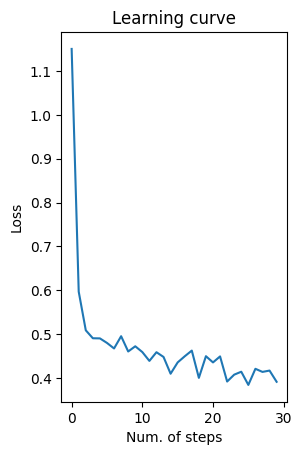

In [ ]:
# Implement the model and create training routine.
def train(model, loss, optimizer, \
          trainingData, \
          learning_rate, steps, batch_size, epochs):


  losses = [];
  for i in range(epochs):
    loader = iter(DataLoader(dataset=trainingData, batch_size=batch_size, shuffle=True))

    for step in range(0, steps):
      input, target = next(loader)
      optimizer.zero_grad() # reset gradiant value to zero
      model.double()
      output = model(input) # pass input to model

      err = loss(output, target)
      losses.append(err) # store err value to monitor training

      err.backward() # evaluate the gradient
      optimizer.step() # propagate the evaluated gradient to update parameters

  return losses

def train_iris_logistic():

  learning_rate = 0.2
  steps = 3
  batch_size = 40
  epochs = 10

  trainingData = IrisDataset(train_features, train_mc)

  iris_model = LogisticRegression(inputSize=4, outputSize=3)
  loss = torch.nn.BCELoss()
  optimizer = torch.optim.SGD(iris_model.parameters(), lr=learning_rate)

  losses = train(iris_model, loss, optimizer, trainingData, learning_rate, steps, batch_size, epochs)
  print("The cross-entropy in training is: ", min(losses))

  losses = torch.stack(losses, dim=0)
  plt.subplot(1, 2, 1)
  plt.plot(range(steps*epochs), losses.detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  return iris_model

iris_model = train_iris_logistic()

Use the testing set to generate predictions with the model. Calculate the prediction accuracy, precision and recall for each of the three classes.

Predictions:  tensor([2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 2, 2, 0])
Accuracy of prediction is:  tensor(0.7000)
Precision (for class 0):  tensor(1.)
Recall (for class 0):  tensor(1.)
Precision (for class 1):  tensor(nan)
Recall (for class 1):  tensor(0.)
Precision (for class 2):  tensor(0.5500)
Recall (for class 2):  tensor(1.)


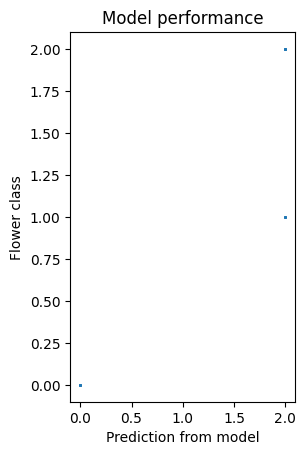

In [ ]:
with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = iris_model(test_features) # note that outputs now indicate probabilities for each class
    predictions = torch.argmax(predictions, 1)
    print("Predictions: ", predictions)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Flower class')
    plt.title('Model performance')
    plt.plot(predictions, test_target, 'o', markersize=.75)

    print("Accuracy of prediction is: ", torch.sum(predictions == test_target)/test_target.shape[0])

    # Calculate precision and recall for each class
    precision = torch.logical_and((predictions == 0), (test_target == 0)).sum() / (predictions == 0).sum()
    recall = torch.logical_and((predictions == 0), (test_target == 0)).sum() / (test_target == 0).sum()
    print("Precision (for class 0): ", precision)
    print("Recall (for class 0): ", recall)

    precision = torch.logical_and((predictions == 1), (test_target == 1)).sum() / (predictions == 1).sum()
    recall = torch.logical_and((predictions == 1), (test_target == 1)).sum() / (test_target == 1).sum()
    print("Precision (for class 1): ", precision)
    print("Recall (for class 1): ", recall)

    precision = torch.logical_and((predictions == 2), (test_target == 2)).sum() / (predictions == 2).sum()
    recall = torch.logical_and((predictions == 2), (test_target == 2)).sum() / (test_target == 2).sum()
    print("Precision (for class 2): ", precision)
    print("Recall (for class 2): ", recall)

## Naive Bayes Classifier

### Revisiting the formulation of Linear Regression

In general, frequentists think about Linear Regression as follows:

$$
Y = \theta^T X + \epsilon
$$

where `𝑌` is the output we want to predict (or dependent variable), `𝑋` is our predictor (or independent variable), and $\theta$ are the coefficients (or parameters) of the model we want to estimate. 𝜖 is an error term which is assumed to be normally distributed.

We can then use Ordinary Least Squares or Maximum Likelihood to find the best fitting $\theta$.

### Probabilistic Reformulation

Bayesians take a probabilistic view of the world and express this model in terms of probability distributions. Our above linear regression can be rewritten to yield:
$$
Y \sim \mathcal{N}(\theta^T X, \sigma^2)
$$

In words, we view `𝑌` as a random variable (or random vector) of which each element (data point) is distributed according to a Normal distribution. Our model will now predict the **expected value** and **standard deviation** of the output using the parameters and the input.

Instead of estimating the maximum likelihood (equivalent to minimum cross-entropy), our model aims to estimate the *posterior* distribution of model parameters *given* the observed data:

$$p(\theta|D) = p(\theta|X,y)$$

Using the bayes formula:

$$p(\theta|X,y) = \frac{p(\theta,X,y)}{p(X,y)} = \frac{p(y|\theta,X)p(\theta|X)p(X)}{p(y|X)p(X)} = \frac{p(y|\theta,X)p(\theta|X)}{p(y|X)}$$

where $p(\theta|X)$ is the **prior distribution**, $p(y|\theta,X)$ is the **likelihood** of the outputs given the parameters, modeled by the training data, and $p(\theta|X,y)$ is the **posterior distribution** of the parameters given the observed data.

We have already defined the likelihood to be univariate normal.

While this is essentially the same model, there are two critical advantages of Bayesian estimation:

* Priors: We can quantify any prior knowledge we might have by placing priors on the paramters. For example, if we think that $\sigma$ is likely to be small we would choose a prior with more probability mass on low values.

* Quantifying uncertainty: We do not get a single estimate of $\theta$ but instead a complete posterior distribution about how likely different values of $\theta$ are. For example, with few data points our uncertainty in $\theta$ will be very high and we’d be getting very wide posteriors.


## Exercise: Flower classification with Linear Bayes Regression

Let's revisit the flower identification task on the Iris flower data set and try to implement a Naive Bayes classifier to identify the correct Iris flower class given a set of formal properties from a sample flower.

In the Naive Bayes model, each Iris flower class will have a specific probability distribution. In order to represent the distribution of a specific class, we first separate the training data into 3 separate portions, each containing samples from a given class (labeled 0, 1 or 2).

In [ ]:
## To-do: Extract indices from the training set that have samples from class 0, 1, 2
# Store indices in classX_trainindices

class0_trainidx = (train_mc[:,0] == 1).nonzero()
class1_trainidx = (train_mc[:,1] == 1).nonzero()
class2_trainidx = (train_mc[:,2] == 1).nonzero()

## To-do: Separate train_features into train_features_classX for each class using the indices
# Stored in classX_trainindices

train_features_class0 = train_features[class0_trainidx]
train_features_class1 = train_features[class1_trainidx]
train_features_class2 = train_features[class2_trainidx]

Using the separate collection of examples representing each individual flower class and their formal features, we can now estimate the statistical properties of each random variable representing the flower type. We will use Normal distributions to represent each unique flower distribution.

In [ ]:
## To-do: Write a function for computing the mean of a random variable
# Assume x is the input with multiple samples and features
# Note that each mean corresponding to the average of each individual flower feature should be computed individually
def expval(x):
  return x.sum(dim=0) / x.shape[0]


## To-do: Write a function for computing the scale for a random variable
# Assume x is the input with multiple samples and mean is the mean of x
#  Note that each std. dev. computation  corresponding to the average of each individual flower feature should be computed individually
def var(x, mu):
  return torch.sum((x-mu)**2, dim=0) / x.shape[0]


Using the functions you implemented, summarize the statistical properties of each class distribution with their mean and standard deviation.

Plot the Normal distributions representing each class feature values distribution.

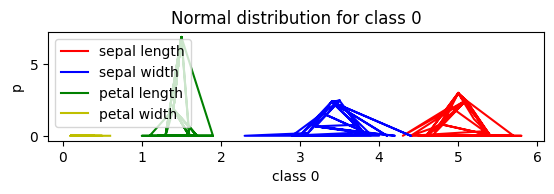

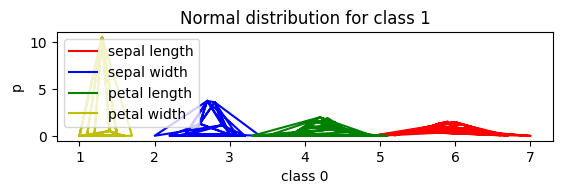

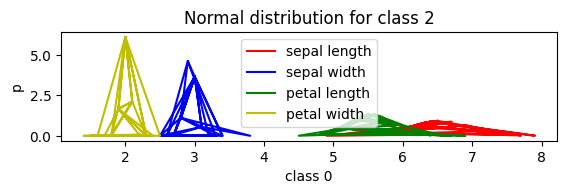

In [ ]:
## To-do: Call implemented functions to create three Gaussian distributions
mean_0 = expval(train_features_class0)
mean_1 = expval(train_features_class1)
mean_2 = expval(train_features_class2)

stddev0 = stddev(train_features_class0, mean_0)
stddev1 = stddev(train_features_class1, mean_1)
stddev2 = stddev(train_features_class2, mean_2)

## To-do: Create a Normal distribution with the given mean and std.dev. values and plot the probability distribution
# corresponding to samples from the training set, from class 0
from torch.distributions.normal import Normal

import matplotlib
import matplotlib.pyplot as plt

m0 = Normal(mean_0, stddev0)

p_0 = []
for i in train_features_class0:
   p_0.append(torch.exp(m0.log_prob(i)))
p_0 = torch.stack(p_0)


plt.subplot(3, 1, 1)
plt.plot(train_features_class0[:,0,0], p_0.detach()[:,0,0], color='r')
plt.plot(train_features_class0[:,0,1], p_0.detach()[:,0,1], color='b')
plt.plot(train_features_class0[:,0,2], p_0.detach()[:,0,2], color='g')
plt.plot(train_features_class0[:,0,3], p_0.detach()[:,0,3], color='y')
plt.title('Normal distribution for class 0')
plt.xlabel('class 0')
plt.legend(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.ylabel('p')
plt.show()

# To-do: Repeat for classes 1 and 2

m1 = Normal(mean_1, stddev1)
m2 = Normal(mean_2, stddev2)

p_1 = []
for i in train_features_class1:
   p_1.append(torch.exp(m1.log_prob(i)))
p_1 = torch.stack(p_1)

p_2 = []
for i in train_features_class2:
   p_2.append(torch.exp(m2.log_prob(i)))
p_2 = torch.stack(p_2)


plt.subplot(3, 1, 2)
plt.plot(train_features_class1[:,0,0], p_1.detach()[:,0,0], color='r')
plt.plot(train_features_class1[:,0,1], p_1.detach()[:,0,1], color='b')
plt.plot(train_features_class1[:,0,2], p_1.detach()[:,0,2], color='g')
plt.plot(train_features_class1[:,0,3], p_1.detach()[:,0,3], color='y')
plt.title('Normal distribution for class 1')
plt.xlabel('class 0')
plt.legend(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.ylabel('p')
plt.show()


plt.subplot(3, 1, 3)
plt.plot(train_features_class2[:,0,0], p_2.detach()[:,0,0], color='r')
plt.plot(train_features_class2[:,0,1], p_2.detach()[:,0,1], color='b')
plt.plot(train_features_class2[:,0,2], p_2.detach()[:,0,2], color='g')
plt.plot(train_features_class2[:,0,3], p_2.detach()[:,0,3], color='y')
plt.title('Normal distribution for class 2')
plt.xlabel('class 0')
plt.legend(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.ylabel('p')
plt.show()

Using the Normal distributions we built to represent each class, we will now use the Naive Bayes approach to classification by predicting the log probability of test samples and assigning the class which has the maximum probability.

The Naive Bayes computation of the joint probability of a given class is formulated by assuming independence across the probabilities of the individual features:

$$
  P(class=0|X1,X2,X3,X4) = P(X1|class=0) * P(X2|class=0) * P(X3|class=0) * P(X4|class=0)
$$

30
torch.Size([])
torch.Size([30])
Accuracy of prediction is:  tensor(0.9000)
Precision (for class 0):  tensor(1.)
Recall (for class 0):  tensor(1.)
Precision (for class 1):  tensor(0.8750)
Recall (for class 1):  tensor(0.7778)
Precision (for class 2):  tensor(0.8333)
Recall (for class 2):  tensor(0.9091)


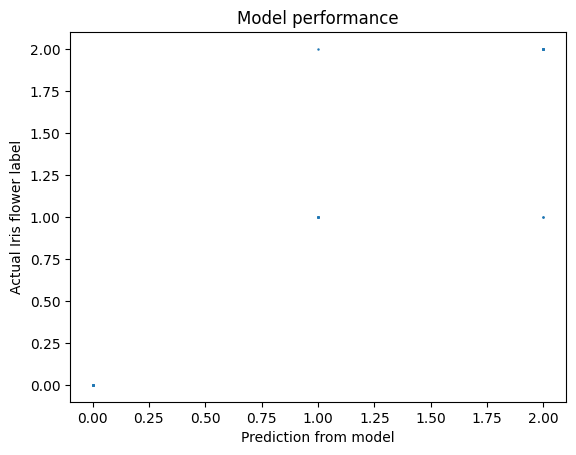

In [ ]:
predictions = []
for sample in test_features:
  p_class0 = m0.log_prob(sample).sum()
  p_class1 = m1.log_prob(sample).sum()
  p_class2 = m2.log_prob(sample).sum()
  predictions.append(torch.argmax(torch.tensor([p_class0, p_class1, p_class2])))

predictions = torch.stack(predictions)

with torch.no_grad():
    plt.plot(predictions, test_target, 'o', markersize=.75)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual Iris flower label')
    plt.title('Model performance')

    print("Accuracy of prediction is: ", torch.sum(predictions == test_target)/test_target.shape[0])

    # To-do: Calculate precision and recall for each class
    precision = torch.logical_and((predictions == 0), (test_target == 0)).sum() / (predictions == 0).sum()
    recall = torch.logical_and((predictions == 0), (test_target == 0)).sum() / (test_target == 0).sum()
    print("Precision (for class 0): ", precision)
    print("Recall (for class 0): ", recall)

    precision = torch.logical_and((predictions == 1), (test_target == 1)).sum() / (predictions == 1).sum()
    recall = torch.logical_and((predictions == 1), (test_target == 1)).sum() / (test_target == 1).sum()
    print("Precision (for class 1): ", precision)
    print("Recall (for class 1): ", recall)

    precision = torch.logical_and((predictions == 2), (test_target == 2)).sum() / (predictions == 2).sum()
    recall = torch.logical_and((predictions == 2), (test_target == 2)).sum() / (test_target == 2).sum()
    print("Precision (for class 2): ", precision)
    print("Recall (for class 2): ", recall)